<a href="https://colab.research.google.com/github/alexunderch/Bachelor_materials/blob/main/ml-mipt_advanced/DL_Research/BootstrappedDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on [link](https://csc2541-f17.github.io/slides/lec08.pdf)

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

prefix = 'https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/week04_approx_rl/'

os.system('wget ' + prefix + 'atari_wrappers.py')
os.system('wget ' + prefix + 'utils.py')
os.system('wget ' + prefix + 'framebuffer.py')

print('setup complete')

Selecting previously unselected package xvfb.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.
setup complete


In [1]:
import random
import numpy as np
import torch
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import utils

import gym
import numpy as np
import matplotlib.pyplot as plt
ENV_NAME = "BeamRider-v0"


In [2]:
from framebuffer import FrameBuffer
%load_ext autoreload
%autoreload 2
import atari_wrappers

from gym.core import ObservationWrapper
from gym.spaces import Box
from PIL import Image



def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

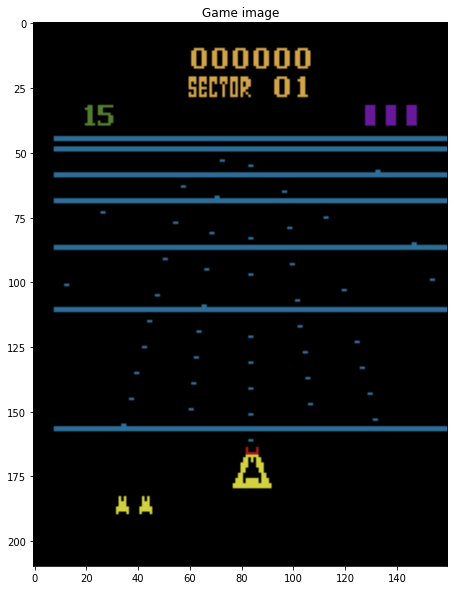

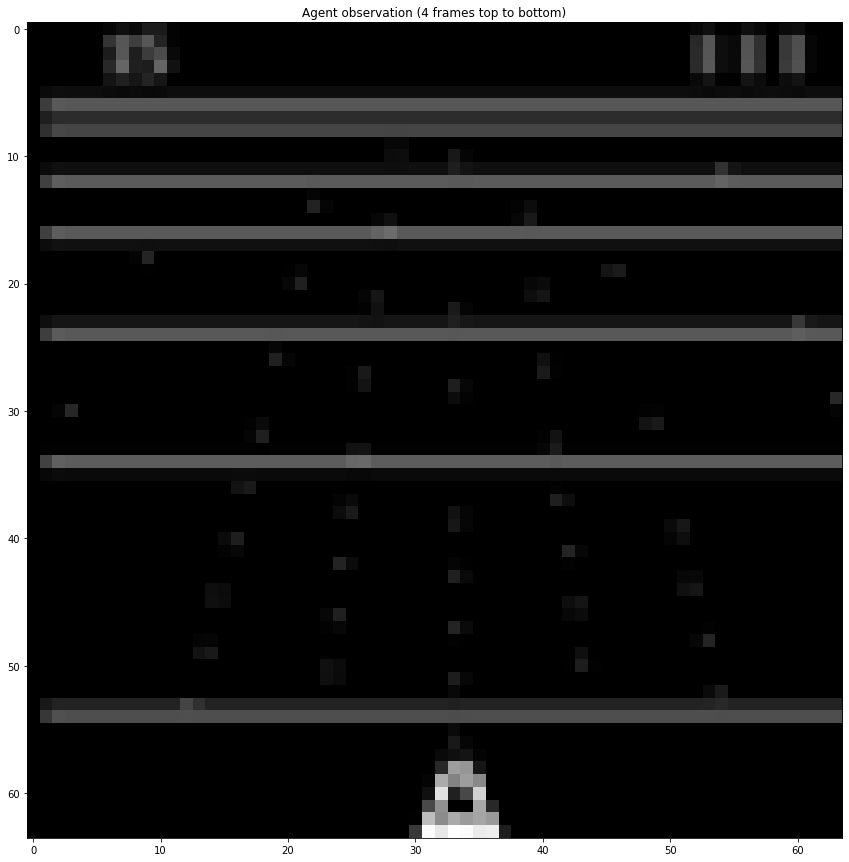

In [3]:
class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.img_c, self.img_h, self.img_w = self.img_size 
        self.observation_space = Box(0.0, 1.0, self.img_size)

    #
    def _to_gray_scale(self, rgb, channel_weights = np.array([0.2989, 0.5870, 0.1140])):
        return np.dot(rgb[..., :3], channel_weights)[..., None]


    def _crop_centre(self, img, cropH, cropW):
      h, w, c = img.shape
      startH = h // 2 - (cropH // 2)
      startW = w // 2 - (cropW // 2)    
      return img[startH : startH + cropH,
                 startW : startW + cropW]

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type

        cropped_img = self._crop_centre(img, 150, 150)
        resized_img = np.array(Image.fromarray(cropped_img).resize((self.img_h, self.img_w)))
        greyscaled_img = self._to_gray_scale(resized_img).reshape(self.img_size)
        return greyscaled_img.astype(np.float32) / 255

def PrimaryAtariWrap(env, clip_rewards=True):
    # assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

env = gym.make(ENV_NAME)  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

_ = env.reset()

for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, observation_shape), cmap='gray')
plt.show()

In [4]:
import numpy as np
import random


class ReplayBuffer(object):
    def __init__(self, size, p: float = 1., heads: int = 1):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self.bernoulli_probability = p
        self.num_heads = heads
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done, self.bernoulli_probability)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones, masks = [], [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done, _ = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
            masks.append(np.random.binomial(1, self.bernoulli_probability, size = self.num_heads))
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones), np.array(masks)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

# Bootstrapped DQN

In [5]:
def conv2d_size_out(size, kernel_size = 3, stride = 2):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1



def evaluate(env, agent, k: int, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s], k)
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break

        rewards.append(reward)
    return np.mean(rewards)

def play_and_record(initial_state, agent, k: int, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s], k)
        a = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(a)
        # Play the game for n_steps as per instructions above
        if exp_replay is not None:
            # store current <s,a,r,s'> transition in buffer
            exp_replay.add(s, a, r, next_s, done)
        sum_rewards += r
        if done:  env.reset()
        else: s = next_s 


    return sum_rewards, s

In [6]:
class CoreNet(nn.Module):
    def __init__(self, state_shape):
        super().__init__()
        self.state_shape = state_shape

        self.conv0 = nn.Conv2d(self.state_shape[0], 16, kernel_size = (3, 3), stride = (2, 2))
        self.conv1 = nn.Conv2d(16, 32, kernel_size = (3, 3), stride = (2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), stride = (2, 2))
        self.flatten = nn.Flatten()

    def forward(self, state_t):
          x = F.relu(self.conv0(state_t))
          x = F.relu(self.conv1(x))
          x = F.relu(self.conv2(x))
          out = self.flatten(x)
          return out

class DuelingPart(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()
        self.n_actions = n_actions
        w = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape)))
        h = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape)))
        self.dense1 = nn.Linear(input_shape * h * w, 512)
        self.dense2 = nn.Linear(512, 256)

        self.logits = nn.Linear(256, self.n_actions)
        self.state_value = nn.Linear(256, 1)

    def forward(self, emb_t):
        x = F.relu(self.dense1(emb_t))
        x = F.relu(self.dense2(x))

        logits = self.logits(x)
        state_value = self.state_value(x)

        qvalues = state_value + (logits - logits.mean(dim = 1, keepdim = True))
        return qvalues

class EnsembleNet(nn.Module):
    def __init__(self, n_ensemble, state_shape, n_actions, epsilon = 1.0):
        super().__init__()
        self.epsilon = epsilon
        self.core_net = CoreNet(state_shape)
        self.net_list = nn.ModuleList([DuelingPart(64, n_actions) for k in range(n_ensemble)])

    def _core(self, state_t):
        return self.core_net(state_t)

    def _heads(self, state_t):
        return [net(state_t) for net in self.net_list]

    def forward(self, state_t, k: int):
        return self.net_list[k](self._core(state_t))

    def get_qvalues(self, states, k: int):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device = model_device, dtype = torch.float)
        qvalues = self.forward(states, k)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p=[1-self.epsilon, self.epsilon])
        return np.where(should_explore, random_actions, best_actions)

class NetWithPrior(nn.Module):
    def __init__(self, net, prior, prior_scale=1./np.sqrt(2)):
        super(NetWithPrior, self).__init__()
        self.net = net
        self.prior_scale = prior_scale
        if self.prior_scale > 0.: self.prior = prior

    def forward(self, state_t, k:int):
        if k is not None:
            if self.prior_scale > 0.: return self.net(state_t, k) + self.prior_scale * self.prior(state_t, k).detach()
            else: return self.net(state_t, k)
        else:
            net_heads = self.net._heads(self.net._core(state_t))
            if self.prior_scale <= 0.: return net_heads
            else:
                prior_heads = self.prior._heads(self.prior._core(state_t))
                return [n + self.prior_scale * p.detach() for n, p in zip(net_heads, prior_heads)]

    def get_qvalues(self, states, k: int):
        states = torch.tensor(states, device = next(self.parameters()).device, dtype = torch.float)
        if k is not None:
            return self.forward(states, k).data.cpu().numpy()
        else: return list(self.forward(states, None))
    
    def sample_actions(self, qvalues):
        if k is not None:
            return self.net.sample_actions(qvalues) 
        else: raise NotImplementedError("")
  

In [7]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

seed = 42 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [8]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()
ensemble_size = 7

agent = NetWithPrior(EnsembleNet(ensemble_size, state_shape, n_actions, epsilon = 1.0), 
                     EnsembleNet(ensemble_size, state_shape, n_actions, epsilon = 1.0)).to(device)
target_network = NetWithPrior(EnsembleNet(ensemble_size, state_shape, n_actions), 
                              EnsembleNet(ensemble_size, state_shape, n_actions)).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [9]:
def compute_td_loss(states, actions, rewards, next_states, is_done, masks,
                    agent, target_network,
                    gamma = 0.99,
                    device = device,
                    double_DQN = True):
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    batch_size = len(states)
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(is_done.astype('float32'), device=device, dtype=torch.float)  # shape: [batch_size]
    is_not_done = 1 - is_done
    masks = torch.tensor(masks, device=device, dtype = torch.float)

    ensemble_losses = np.zeros(ensemble_size, dtype = np.float32)
    # get q-values for all actions in current states
    predicted_qvalues = agent(states, None)
    # compute q-values for all actions in next states
    predicted_next_target_qvalues = [t.detach() for t in target_network(next_states, None)]
    predicted_next_qvalues =[t.detach() for t in agent(next_states, None)]
    
    current_losses = []
    for k in range(ensemble_size):
        next_qvalues = predicted_next_target_qvalues[k]
        if double_DQN:
            prime_actions = predicted_next_qvalues[k].max(1, True)[1]
            next_state_values = next_qvalues.gather(1, prime_actions).squeeze(1)
        else:
            # compute V*(next_states) using predicted next q-values
            next_state_values = torch.max(next_qvalues[k], dim = 1)[0]
        # select q-values for chosen actions
        predicted_qvalues_for_actions =  predicted_qvalues[k].gather(1, actions.unsqueeze(-1)).squeeze(1)

        # print(next_state_values.shape, rewards.shape)
        target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

        tmp_loss = torch.sum(masks[:, k] * F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions, reduction='mean') / (1e-12 + torch.sum(masks[:, k])))
        current_losses.append(tmp_loss)
        ensemble_losses[k] = tmp_loss.cpu().detach().item()
    
    loss = np.sum(current_losses) / ensemble_size

    return loss, np.mean(ensemble_losses)

In [10]:
timesteps_per_epoch = 1
batch_size = 16
total_steps = 3 * 10**6
decay_steps = 10**6
TAU = 1e-2 

opt = torch.optim.Adam(agent.parameters(), lr = 1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [11]:
exp_replay = ReplayBuffer(10**5, p = .5, heads=ensemble_size)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    for k in range(ensemble_size): play_and_record(state, agent, k, env, exp_replay, n_steps=10**2)
    if len(exp_replay) >= 10**5:
        break
print(len(exp_replay))

70000


buffer size = 100000, epsilon = 0.94150


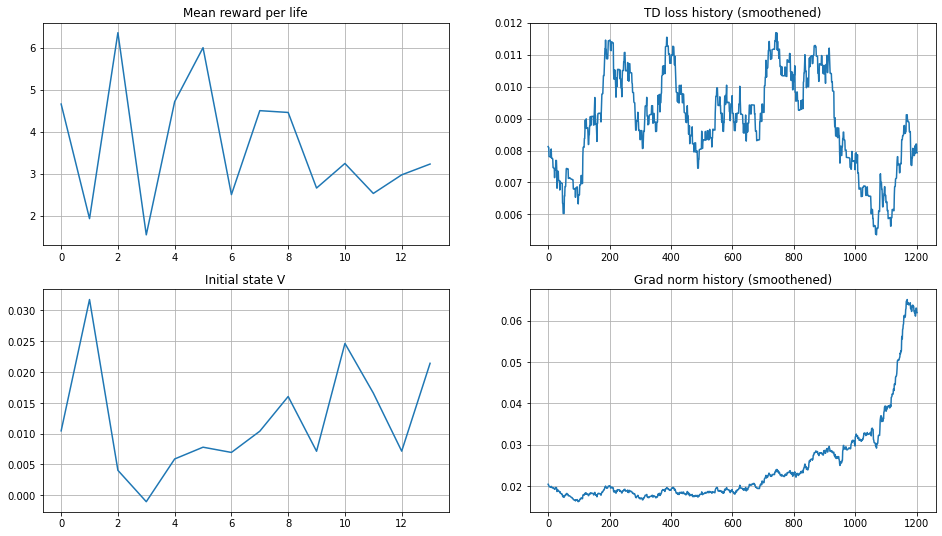

  2%|▏         | 70000/3000001 [1:52:40<56:47:39, 14.33it/s]

In [ ]:
td_loss_history, grad_norm_history, initial_state_v_history, mean_rw_history = [], [], [], []
state = env.reset()
for step in trange(total_steps + 1):
      if not utils.is_enough_ram():
          print('less that 100 Mb RAM available, freezing')
          print('make sure everything is ok and make KeyboardInterrupt to continue')
          try:
              while True: pass
          except KeyboardInterrupt:
              pass

      agent.net.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
      agent.prior.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

      # play
      _, state = play_and_record(state, agent, np.random.randint(0, ensemble_size-1), env, exp_replay, timesteps_per_epoch)

      state_, action, reward, next_state, is_done, mask = exp_replay.sample(batch_size)

      loss, ensemble_losses = compute_td_loss(state_, action, reward, next_state, is_done, mask,
                            agent, target_network, double_DQN = True)
      
      loss.backward()
      grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)

      for param in agent.net.parameters(): 
          if param.grad is not None: param.grad.data *= (1.0 / ensemble_size)
      
      opt.step()
      opt.zero_grad()

      if step % loss_freq == 0:
          td_loss_history.append(ensemble_losses)
          grad_norm_history.append(grad_norm)

      if step % refresh_target_network_freq == 0:
          # Load agent weights into target_network
          for target_param, agent_param in zip(target_network.parameters(), agent.parameters()):
              target_param.data.copy_(TAU * agent_param.data + (1.0 - TAU) * target_param.data)


      if step % eval_freq == 0:

          mean_rw_history.append(
              np.mean([evaluate(
              make_env(clip_rewards = True, seed = step), agent, k, n_games = 2 * n_lives, greedy = True) 
              for k in range(ensemble_size)
              ]))
          
          if step > 0:
              if mean_rw_history[-1] >= mean_rw_history[-2]:
                  torch.save(agent, "agent.model")
                  torch.save(target_network, "target_network.model")
              
          initial_state_q_values = np.mean([agent.get_qvalues(
              [make_env(seed = step).reset()], k) 
              for k in range(ensemble_size)])
          
          initial_state_v_history.append(np.max(initial_state_q_values))

          clear_output(True)
          print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.net.epsilon))

          plt.figure(figsize=[16, 9])

          plt.subplot(2, 2, 1)
          plt.title("Mean reward per life")
          plt.plot(mean_rw_history)
          plt.grid()

          assert not np.isnan(td_loss_history[-1])
          plt.subplot(2, 2, 2)
          plt.title("TD loss history (smoothened)")
          plt.plot(utils.smoothen(td_loss_history))
          plt.grid()

          plt.subplot(2, 2, 3)
          plt.title("Initial state V")
          plt.plot(initial_state_v_history)
          plt.grid()

          plt.subplot(2, 2, 4)
          plt.title("Grad norm history (smoothened)")
          plt.plot(utils.smoothen(grad_norm_history))
          plt.grid()

          plt.show()